In [134]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
docs = ['this is a test ', 'this is also a test', 'why and I still testing this', 'ok now the test is over']


class SkipGram:
    def __init__(self, max_len=5, tokenizer=None):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.words = None
        self.probs = None
        self.n_words = None
        if tokenizer:
            self._setup_words()
        pass

    def _setup_words(self):
        self.n_words = sum(self.tokenizer.word_counts.values())
        self.words = np.array(list(self.tokenizer.word_counts.keys()))
        self.probs = np.array(list(self.tokenizer.word_counts.values()))/self.n_words

    def fit(self, docs):
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(docs)
        self._setup_words()

    def _text_to_padded_sequences(self, docs):
        seqs = self.tokenizer.texts_to_sequences(docs)
        seqs_padded = pad_sequences(seqs, maxlen=self.max_len, padding='post', truncating='post')
        return seqs_padded
    def text_to_seq(self, docs):
        seqs = self.tokenizer.texts_to_sequences(docs)
        seqs_padded = pad_sequences(seqs, maxlen=self.max_len-1, padding='post', truncating='post')
        return seqs_padded
    def _random_choice_int(self, v):
        new_word = np.random.choice(self.words, 1, p=self.probs)[0]
        output = self.tokenizer.word_index[new_word]
        if v == output:
            new_word = np.random.choice(self.words, 1, p=self.probs)[0]
            output = self.tokenizer.word_index[new_word]
        
        return output

    def _missing_word_gen(self, docs):
        seqs = self._text_to_padded_sequences(docs)
        for seq in seqs:
            seq = np.array(seq)
            if sum(seq) != 0:
                for i in range(self.max_len):
                    new_seq = np.delete(seq, i)
                    x = np.array([new_seq, new_seq])
                    word_index = seq[i]
                    new_word_index = self._random_choice_int(word_index)
                    context = np.array([[word_index], [new_word_index]])
                    label = np.array([[1], [0]])
                    yield x, context, label

    def array_to_texts(self, x):
        return list(s.tokenizer.sequences_to_texts_generator(x))
    
    def transform_gen(self, docs, batch_size=32):
        gen = self._missing_word_gen(docs)
        try:
            while True:
                array_list = [next(gen) for _ in range(int(batch_size))]
                x = np.vstack([v[0] for v in array_list])
                context = np.vstack([v[1] for v in array_list])
                labels = np.vstack([v[2] for v in array_list]).flatten()
                yield x, context, labels
        except StopIteration:
            print('completed')

    def transform(self, docs):
        array_list = list(self._missing_word_gen(docs))
        x = np.vstack([v[0] for v in array_list])
        context = np.vstack([v[1] for v in array_list])
        labels = np.vstack([v[2] for v in array_list]).flatten()
        return x, context, labels

test_docs = ['this is a test', 'this is still a test', 'why am I still testing', '']
s = SkipGram(max_len = 7)
s.fit(test_docs)
test_x, test_context, test_labels = s.transform(test_docs)
list(zip(s.array_to_texts(test_x,), s.array_to_texts( test_context),test_labels ))


[('is a test', 'this', 1),
 ('is a test', 'is', 0),
 ('this a test', 'is', 1),
 ('this a test', 'still', 0),
 ('this is test', 'a', 1),
 ('this is test', 'am', 0),
 ('this is a', 'test', 1),
 ('this is a', 'testing', 0),
 ('this is a test', '', 1),
 ('this is a test', 'why', 0),
 ('this is a test', '', 1),
 ('this is a test', 'a', 0),
 ('this is a test', '', 1),
 ('this is a test', 'testing', 0),
 ('is still a test', 'this', 1),
 ('is still a test', 'test', 0),
 ('this still a test', 'is', 1),
 ('this still a test', 'why', 0),
 ('this is a test', 'still', 1),
 ('this is a test', 'a', 0),
 ('this is still test', 'a', 1),
 ('this is still test', 'this', 0),
 ('this is still a', 'test', 1),
 ('this is still a', 'still', 0),
 ('this is still a test', '', 1),
 ('this is still a test', 'is', 0),
 ('this is still a test', '', 1),
 ('this is still a test', 'is', 0),
 ('am i still testing', 'why', 1),
 ('am i still testing', 'still', 0),
 ('why i still testing', 'am', 1),
 ('why i still testing

## Download 2020 ICD 10 Codes from the CDC

In [136]:
from urllib import request as ur
import pandas as pd
url = 'ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Publications/ICD10CM/2020/icd10cm_codes_2020.txt'
req = ur.Request(url)
file = ur.urlopen(req)


df = pd.read_csv(file,  header=None, sep='\t')

# parses out the code descripitions
docs = list(map(lambda x: re.sub('[A-Z][0-9]+', '', x).strip(), df.iloc[:, 0]))
# parest out the actuall codes 
codes = list(map(lambda x: re.search('[A-Z][0-9]+', x).group(), df.iloc[:, 0]))
 

In [111]:
# calculated the max sequence len
np.max([len(d.split(' ')) for d in docs])

31

In [144]:
max_len = 31
s = SkipGram(max_len=max_len)
s.fit(docs)
vocab_size = len(s.tokenizer.word_index)
context_size = 1

In [146]:
vocab_size

7212

In [157]:

from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Flatten, Dense, BatchNormalization
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from keras.callbacks import EarlyStopping
esm =  EarlyStopping(patience=2, monitor='loss')

dim_embedddings =10
n_w_inputs = max_len-1 

# inputs
w_inputs = Input(shape=(n_w_inputs, ), dtype='int32')
w = Embedding(vocab_size+1, dim_embedddings,name= 'embx')(w_inputs)

# context
c_inputs = Input(shape=(context_size, ), dtype='int32')
c  = Embedding(vocab_size+1, dim_embedddings, name= 'embc')(c_inputs)
o = Dot(axes=2)([w, c])
o = BatchNormalization()(o)
o = Reshape((1, n_w_inputs), input_shape=(n_w_inputs, 1))(o)
o = Flatten(name='flatten')(o)
o = Dense(1)(o)
o = Activation('sigmoid')(o)

model = Model(inputs=[w_inputs, c_inputs], outputs=o)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
# fit the model


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 30)           0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embx (Embedding)                (None, 30, 10)       72130       input_17[0][0]                   
__________________________________________________________________________________________________
embc (Embedding)                (None, 1, 10)        72130       input_18[0][0]                   
____________________________________________________________________________________________

In [158]:
def train(doc, n_epochs=1, skipgram=s, model=model, batch_size=512):
    for e in range(n_epochs):
        gen = s.transform_gen(docs, batch_size=batch_size)
        try:
            while True:
                x, context, y = next(gen)
                model.train_on_batch([x, context], y)
        except StopIteration:
            pass
    return model
model = train(docs, 1, s,  model)

completed


In [160]:
emb_input = Input(shape=(max_len-1, ), dtype='int32')
emb_layer = model.get_layer('embx')(emb_input )
emb_model = Model(inputs=emb_input, outputs=emb_layer)

seqs = s.text_to_seq(docs)
seqs[1:3]

array([[3794,   58,   24, 3159, 3795, 4331, 4332, 4944,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [3794,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [161]:
vects = emb_model.predict(seqs)
vects.shape

(72184, 30, 10)

In [162]:
vecs_reshape = np.reshape(vects, (vects.shape[0], -1))
vecs_reshape.shape

(72184, 300)

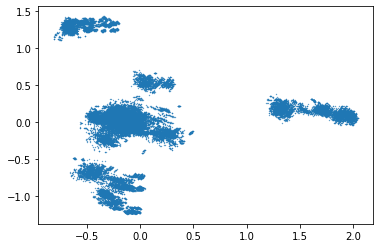

In [163]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
p = PCA(2).fit(vecs_reshape)
comps = p.transform(vecs_reshape)
xx = comps[:, 0]
yy = comps[:, 1]
plt.scatter(xx, yy,s=.1)
plt.show()

In [164]:
from keras.layers import GaussianNoise
ac_inputs = Input(shape=(30,10), dtype='float32')
ac_flat = Flatten()(ac_inputs)
ac_dense0 = Dense(30, name='d0')(ac_flat)
ac_noise = GaussianNoise(1)(ac_dense0)
ac_dense1 = Dense(300)(ac_noise) 
ac_reshape = Reshape((30,10))(ac_dense1)
ac_outputs = Activation('linear')(ac_reshape)

ae = Model(inputs=ac_inputs, outputs=ac_outputs)
ae.summary()
ae.compile(loss='mse', optimizer='adam')

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 30, 10)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
d0 (Dense)                   (None, 30)                9030      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               9300      
_________________________________________________________________
reshape_7 (Reshape)          (None, 30, 10)            0         
_________________________________________________________________
activation_7 (Activation)    (None, 30, 10)            0   

In [165]:
ae.fit(vects, vects, epochs=10, callbacks=[esm])

Epoch 1/10
72184/72184 [==============================] - 3s 38us/step - loss: 0.0125
Epoch 2/10
72184/72184 [==============================] - 2s 34us/step - loss: 0.0056
Epoch 3/10
72184/72184 [==============================] - 2s 34us/step - loss: 0.0045
Epoch 4/10
72184/72184 [==============================] - 3s 37us/step - loss: 0.0038
Epoch 5/10
72184/72184 [==============================] - 3s 36us/step - loss: 0.0035
Epoch 6/10
72184/72184 [==============================] - 3s 35us/step - loss: 0.0033
Epoch 7/10
72184/72184 [==============================] - 3s 39us/step - loss: 0.0033
Epoch 8/10
72184/72184 [==============================] - 2s 33us/step - loss: 0.0033
Epoch 9/10
72184/72184 [==============================] - 2s 34us/step - loss: 0.0032
Epoch 10/10
72184/72184 [==============================] - 3s 36us/step - loss: 0.0032


In [168]:
# create the final doc to vect transformer
d2v_in = Input(shape=(max_len-1, ), dtype='int32')
d2v__emb_layer = model.get_layer('embx')(d2v_in)
d2v_flat = Flatten()(d2v__emb_layer)
d2v_output = ae.get_layer('d0')(d2v_flat )

d2v = Model(inputs=d2v_in, outputs=d2v_output )

doc_vects = d2v.predict(seqs)
doc_vects.shape
doc_vects[1:3]


array([[ 1.9844742e+00, -1.1262115e+00,  2.4850941e+00,  1.5158374e+00,
        -1.0119201e+00, -2.1898057e+00, -1.3320541e+00,  1.1337572e+00,
        -1.0395868e+00, -1.3976133e+00,  8.8617080e-01,  4.3655410e-01,
         2.4043121e+00,  5.2443439e-01,  2.0493019e+00,  3.3933029e-02,
         4.7819394e-01,  1.5459973e-01, -2.3181202e-01,  1.0253621e+00,
        -8.1109989e-01, -1.5020680e+00, -8.6862034e-01, -1.5117447e+00,
         7.7139717e-01,  2.6804390e+00, -5.1628816e-01,  1.3258536e+00,
        -6.9219422e-01,  1.0987523e+00],
       [ 2.0901849e+00, -2.3151495e+00,  1.0068781e+00,  2.7547815e+00,
         2.1879272e+00, -1.6304355e+00, -2.1256528e+00,  1.2087435e+00,
         2.4738729e+00, -8.8784432e-01,  2.3763177e+00,  2.4174729e-01,
         7.9300082e-01,  1.1398114e+00,  7.5968140e-01, -1.2411315e+00,
        -1.6450223e+00,  5.8768851e-01,  1.2607078e-01,  4.7965968e-01,
         3.7179196e-01,  9.8991692e-02,  3.6701506e-01, -1.6502832e+00,
         3.3141339e+00,

In [ ]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(5)
nn = nn.fit(doc_vects)


In [185]:
code_dict = dict(zip(codes, doc_vects))
# need to save the tokenizer 
# need to add variable sequence length code doc to vect.  

x = s.text_to_seq(['septic shock'])
preds = d2v.predict(x)
codes[nn.kneighbors(x)[1][0][0]]

'M84379'

(array([[1009.36755651, 1009.43514457, 1009.50618548, 1009.50753122,
         1009.64218857]]), array([[64509, 67725, 58343, 65523, 58340]]))

In [178]:
codes[16438]

'M84379'